In [8]:
import chess
from chess import pgn
import pgnsplit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data saving
import pickle

# Interactive visualization
import plotly.express as px
from dash import Dash, dcc, html, Input, Output

sns.set_theme()

In [3]:
# Redundant cell, use pickle.load below
# Get data in case kernel resets, takes 30s to run on charger
"""pgn_path = open("D:\Datasets\lichess_db_standard_rated_2015-07.pgn")
gamelist = []
for i in tqdm(range(50000)):
    gamelist.append(pgn.read_game(pgn_path))

# Pickle data to access easily later on
pickle.dump(gamelist, open('gamelist.pkl', 'wb'))"""

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:24<00:00, 594.34it/s]


In [2]:
# Load pickled data
gamelist = pickle.load(open('./gamelist.pkl', 'rb'))

# Cell to import everything saved so far
square_freq = pd.read_csv("squarefrequencycount.csv", header=0, index_col="File")
square_freq_K = pd.read_csv("sfc_king.csv", header=0, index_col="File")
square_freq_Q = pd.read_csv("sfc_queen.csv", header=0, index_col="File")
square_freq_R = pd.read_csv("sfc_rook.csv", header=0, index_col="File")
square_freq_B = pd.read_csv("sfc_bishop.csv", header=0, index_col="File")
square_freq_N = pd.read_csv("sfc_knight.csv", header=0, index_col="File")
square_freq_P = pd.read_csv("sfc_pawn.csv", header=0, index_col="File")

heatmap_df_list = [
    square_freq,
    square_freq_K,
    square_freq_Q,
    square_freq_R,
    square_freq_B,
    square_freq_N,
    square_freq_P,
]

piece_count = pd.read_csv("stackedareacounts.csv", index_col="Ply")

checkmate_heatmap = pd.read_csv("checkmate_heatmap.csv", header=0, index_col="File")
checkmate_piece_count = pd.read_csv("checkmate_piece_count.csv", header=0)

game_end = pd.read_csv("game_end_count.csv", header=0)
games_per_month = pd.read_csv("gamespermonth.csv", header=0)

# 3d dataframe for pc all according to elo range
pc_all = pickle.load(open('./pc_all_list.pkl', 'rb'))

# Lists of movecounts per elo range
movecounts_elo = pickle.load(open('./movecounts_elo.pkl', 'rb'))

In [3]:
# Informational data structures
piecedict = {"K": "King", "Q": "Queen", "R": "Rook", "B": "Bishop", "N": "Knight"}
piece_list = ['Q', 'R', 'B', "N"]

In [15]:
# Function to return moves in a game as a list of strings
def get_movelist(game):
    move_list = []
    for move in game.mainline_moves():
        move_list.append(board.san(move))
        board.push(move)
    return move_list

def getsquarefreqcount(game):
    board = game.board()
    for move in game.mainline_moves():
        move_str = str(move)
        str2 = list(move_str[2:4]) # str[file, rank]
        square_freq.loc[str2[0]][str2[1]] += 1
        board.push(move)

    
for game in tqdm(gamelist):
    board = game.board()
    for move in game.mainline_moves():
        move_str = str(move)
        sq = list(move_str[2:4])
        square_freq.loc[sq[0]][sq[1]] += 1
        
        move_san = board.san(move)
        match list(move_san)[0]:
            case "K":
                square_freq_K.loc[sq[0]][sq[1]] += 1
            case "Q":
                square_freq_Q.loc[sq[0]][sq[1]] += 1
            case "R":
                square_freq_R.loc[sq[0]][sq[1]] += 1
            case "B":
                square_freq_B.loc[sq[0]][sq[1]] += 1
            case "N":
                square_freq_N.loc[sq[0]][sq[1]] += 1
            case "O": # Castling is considered a king move
                square_freq_K.loc[sq[0]][sq[1]] += 1
            case _:
                square_freq_P.loc[sq[0]][sq[1]] += 1
        board.push(move)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [07:39<00:00, 108.91it/s]


AttributeError: 'Text' object has no attribute 'invert_yaxis'

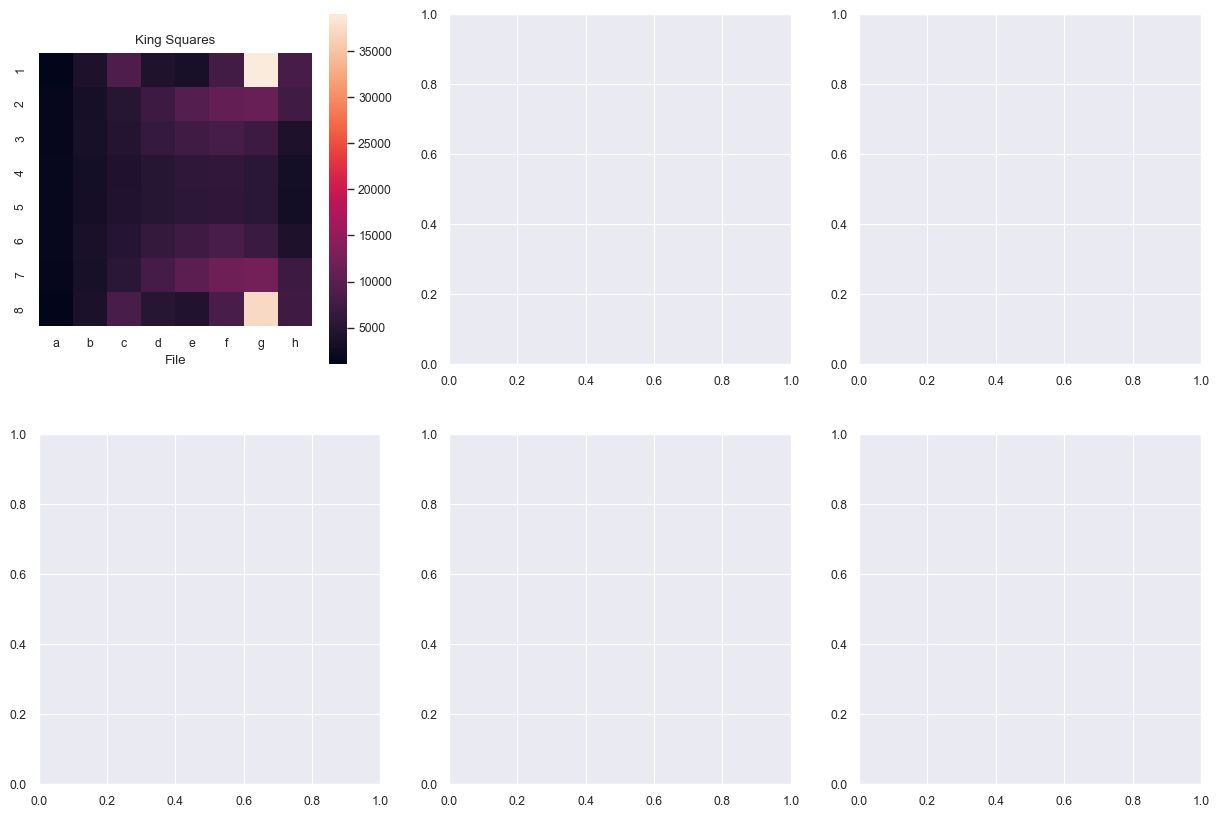

In [60]:
# Plot piece square frequency

fig, ax = plt.subplots(2,3, figsize=(15,10))
sns.heatmap(square_freq_K.transpose(), square=True, ax=ax[0,0])
ax[0,0].set_title("King Squares")
ax[0,0].invert_yaxis()
sns.heatmap(square_freq_Q.transpose(), square=True, ax=ax[0,1])
ax[0,1].set_title("Queen Squares")
sns.heatmap(square_freq_R.transpose(), square=True, ax=ax[0,2])
ax[0,2].set_title("Rook Squares")
sns.heatmap(square_freq_B.transpose(), square=True, ax=ax[1,0])
ax[1,0].set_title("Bishop Squares")
sns.heatmap(square_freq_N.transpose(), square=True, ax=ax[1,1])
ax[1,1].set_title("Knight Squares")
sns.heatmap(square_freq_P.transpose(), square=True, ax=ax[1,2])
ax[1,2].set_title("Pawn Squares")
plt.show()
# Integrate above into radio buttons cuz theyre cool

# Plot overall square frequency
sns.heatmap(square_freq.transpose(), square=True)

In [79]:
# Heatmap but radioitem-ed
app = Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Square usage frequency for each piece type"),
    dcc.RadioItems(
        id='radio-buttons',
        options=[
            {'label': 'Overall', 'value': 0},
            {'label': 'King', 'value': 1},
            {'label': 'Queen', 'value': 2},
            {'label': 'Rook', 'value': 3},
            {'label': 'Bishop', 'value': 4},
            {'label': 'Knight', 'value': 5},
            {'label': 'Pawn', 'value': 6},
        ],
        value=0
    ),
    html.Div(id='display-heatmap')
])

# Define callback function to update the displayed heatmap based on the selected radio button
@app.callback(
    Output('display-heatmap', 'children'),
    [Input('radio-buttons', 'value')]
)
def display_heatmap(selected_heatmap):
    fig = px.imshow(
        heatmap_df_list[selected_heatmap].transpose(), 
        color_continuous_scale = "Inferno"
    )
    fig.update_yaxes(autorange=True) # Invert ranks for accurate board view
    fig.update_layout(
        yaxis_scaleanchor="x", # Make heatmap cells square
        xaxis_title="File",
        yaxis_title="Rank",
        font=dict(
            family="Courier new, monospace",
            size=18
        )
    )

    return dcc.Graph(
        id='heatmap-graph',
        figure=fig,
    )

app.run_server(Debug = True)

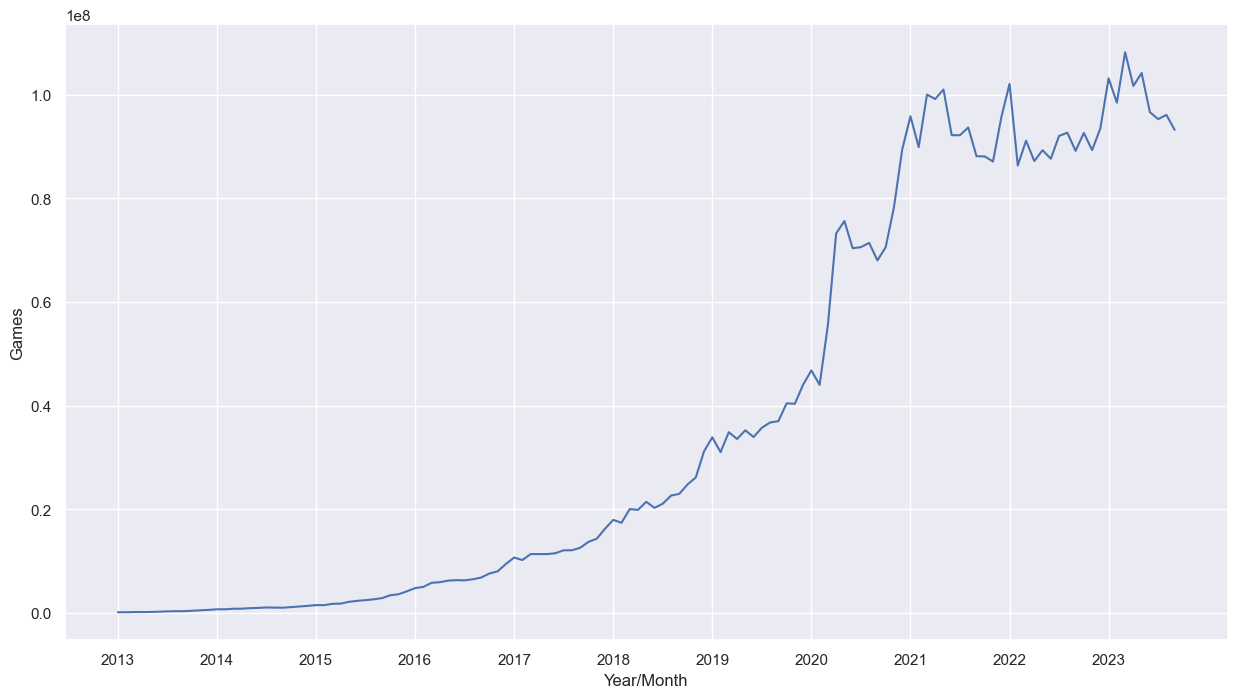

In [22]:
# Games every month from 2013 to 2023 Aug
#games_per_month.plot(x="Year/Month", y="Games", figsize=(12,8))

fig, ax = plt.subplots(figsize=(15,8))
g = sns.lineplot(data=games_per_month, x="Year/Month", y="Games")
x = range(0, len(games_per_month), 12)
g.set_xticks(x, range(2013, 2024))
plt.show()

In [64]:
# Stacked line graph for piece contribution for moves over a game (each x axis is one ply)
# Can be both absolute value and percentage contribution cuz lesser long games
# Can also be used to illustrate distribution of move count in games
# Table with rows = move index, columns = piece category (6 cols)
# OPTIONAL: can see how elo range varies, but may need larger dataset, run if confident all code works
# use plt.stackplot

# 1) Iterate through game
# 2) Identify piece type and increment in corresponding row+col
# 3) Use ply counter to increment 

def addPiece(df, ply_ctr, piece):
    if(piece.isupper()):
        try:
            df.at[ply_ctr, piecedict[piece]] += 1
        except:
            df.at[ply_ctr, piecedict[piece]] = 1
    else:
        try:
            df.at[ply_ctr, "Pawn"] += 1
        except:
            df.at[ply_ctr, "Pawn"] = 1
    
# df to store counts
piece_count = pd.DataFrame(columns=["Pawn", "Knight", "Bishop", "Rook", "Queen", "King"])

for game in tqdm(gamelist):
    # Skip abandoned games
    ply_ctr = 0
    if(game.headers["Termination"] == "Abandoned"):
        continue
        
    board = game.board()
    for move in game.mainline_moves():
        move_san = board.san(move)
        piece = list(move_san)[0]
        addPiece(piece_count, ply_ctr, piece)
        board.push(move)
        ply_ctr += 1
    piece_count.fillna(0, inplace=True)

'piece_count = pd.DataFrame(columns=["Pawn", "Knight", "Bishop", "Rook", "Queen", "King"])\n\nfor game in tqdm(gamelist):\n    # Skip abandoned games\n    ply_ctr = 0\n    if(game.headers["Termination"] == "Abandoned"):\n        continue\n        \n    board = game.board()\n    for move in game.mainline_moves():\n        move_san = board.san(move)\n        piece = list(move_san)[0]\n        addPiece(piece_count, ply_ctr, piece)\n        board.push(move)\n        ply_ctr += 1\n    piece_count.fillna(0, inplace=True)'

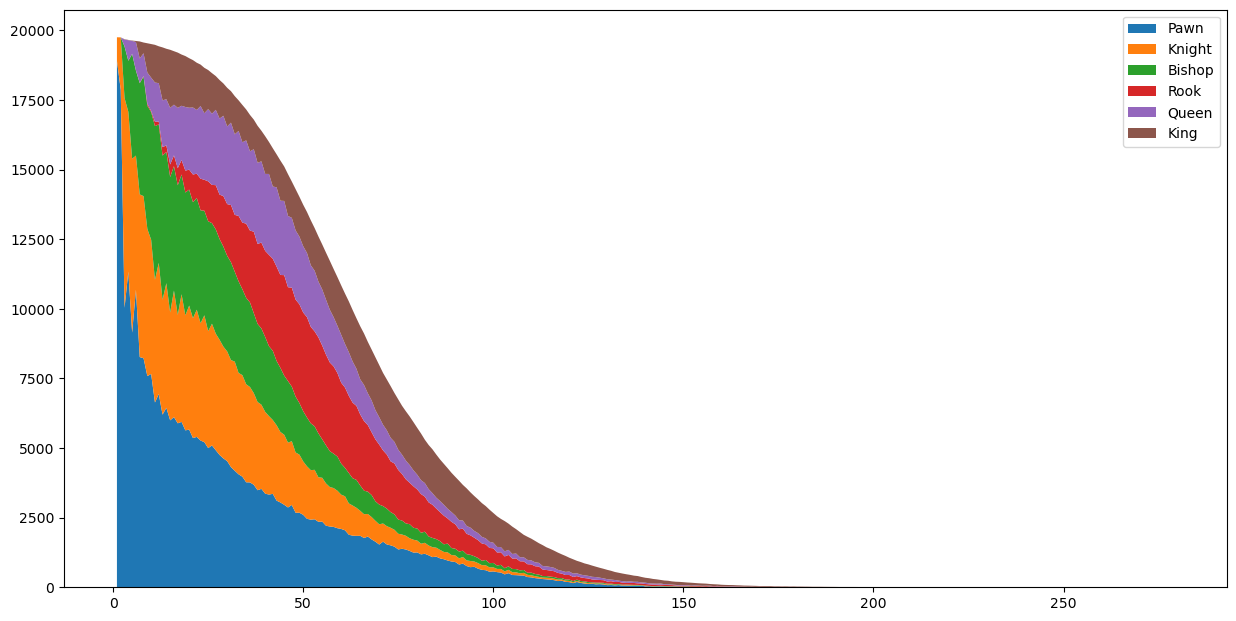

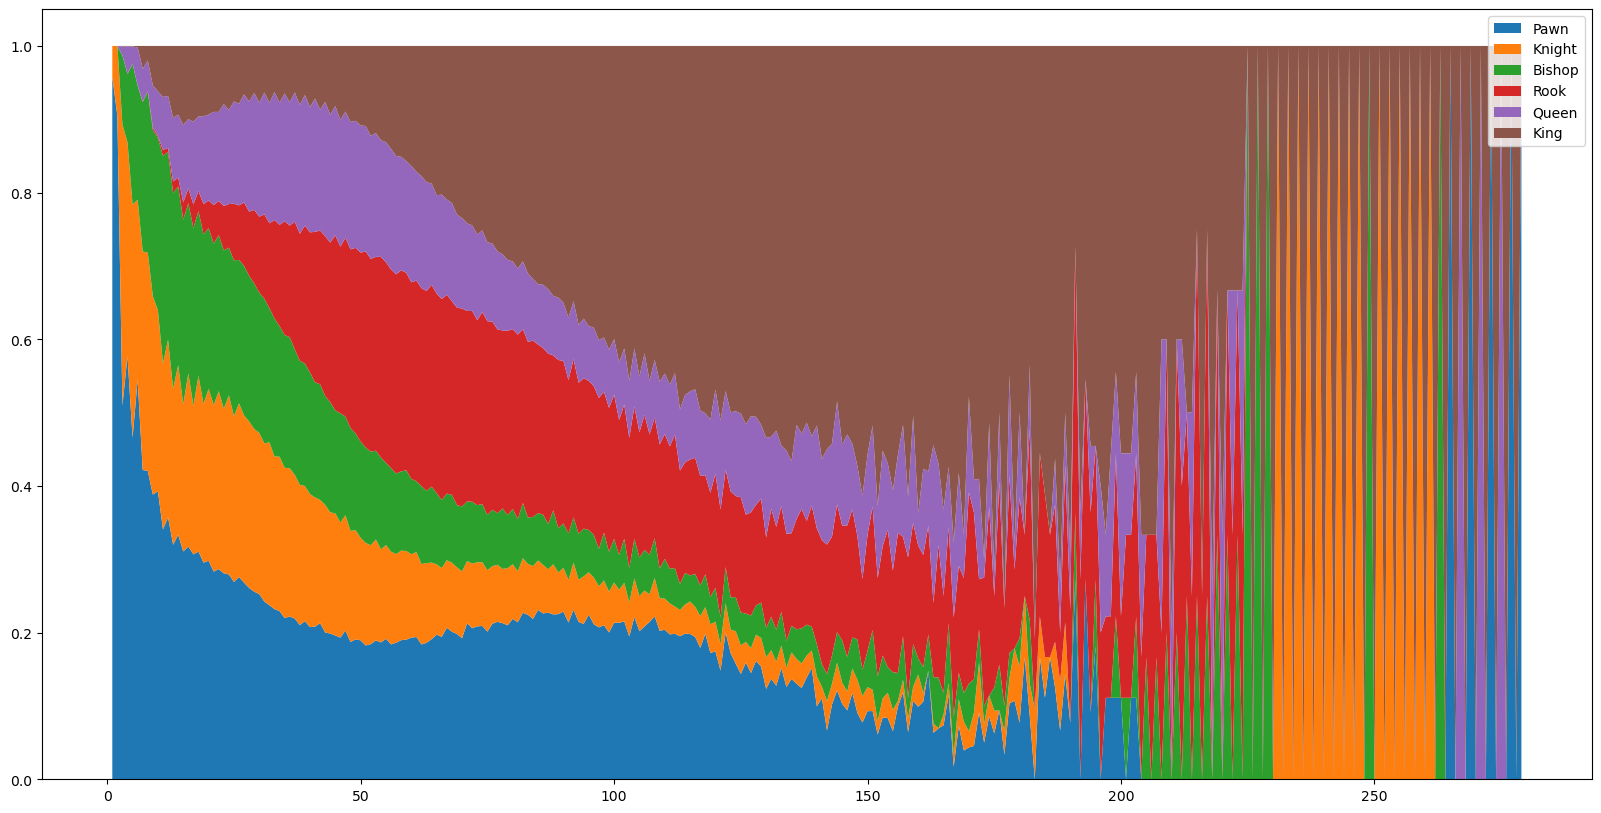

In [50]:
x = list(range(1, len(piece_count)+1))
plt.figure(figsize = (15, 7.5))
plt.stackplot(x, piece_count.transpose())
plt.legend(list(piece_count.columns))
plt.show()
# Can support this first plot with individual violin/boxplot for pieces as game progresses

piece_count_normalized = piece_count.divide(piece_count.sum(axis=1), axis=0)
plt.figure(figsize = (20, 10))
plt.stackplot(x, piece_count_normalized.transpose())
plt.legend(list(piece_count.columns))
plt.show()

In [72]:
# Add average elo range categorization, prune games more than 200 moves long
# cuz lichess, elo bins: <1200, 1200-1500, 1500-1800, 1800-2100, >2100

pc_lower1200, pc_1200, pc_1500, pc_1800, pc_2100higher = (pd.DataFrame(columns=["Pawn", "Knight", "Bishop", "Rook", "Queen", "King"]) for _ in range(5))
pc_all = [pc_lower1200, pc_1200, pc_1500, pc_1800, pc_2100higher]

for game in tqdm(gamelist):
    # Skip abandoned games
    ply_ctr = 0
    if(game.headers["Termination"] == "Abandoned"):
        continue
    
    avg_elo = (int(game.headers["WhiteElo"]) + int(game.headers["BlackElo"]))/2
    board = game.board()
    
    for move in game.mainline_moves():
        move_san = board.san(move)
        piece = list(move_san)[0]
        if(avg_elo < 1200):
            addPiece(pc_lower1200, ply_ctr, piece)
        elif(avg_elo in np.arange(1200, 1500, 0.5)):
            addPiece(pc_1200, ply_ctr, piece)
        elif(avg_elo in np.arange(1500, 1800, 0.5)):
            addPiece(pc_1500, ply_ctr, piece)
        elif(avg_elo in np.arange(1800, 2100, 0.5)):
            addPiece(pc_1800, ply_ctr, piece)
        elif(avg_elo >= 2100):
            addPiece(pc_2100higher, ply_ctr, piece)
            
        board.push(move)
        ply_ctr += 1
    for df in pc_all:
        df.fillna(0, inplace=True)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:45<00:00, 144.68it/s]


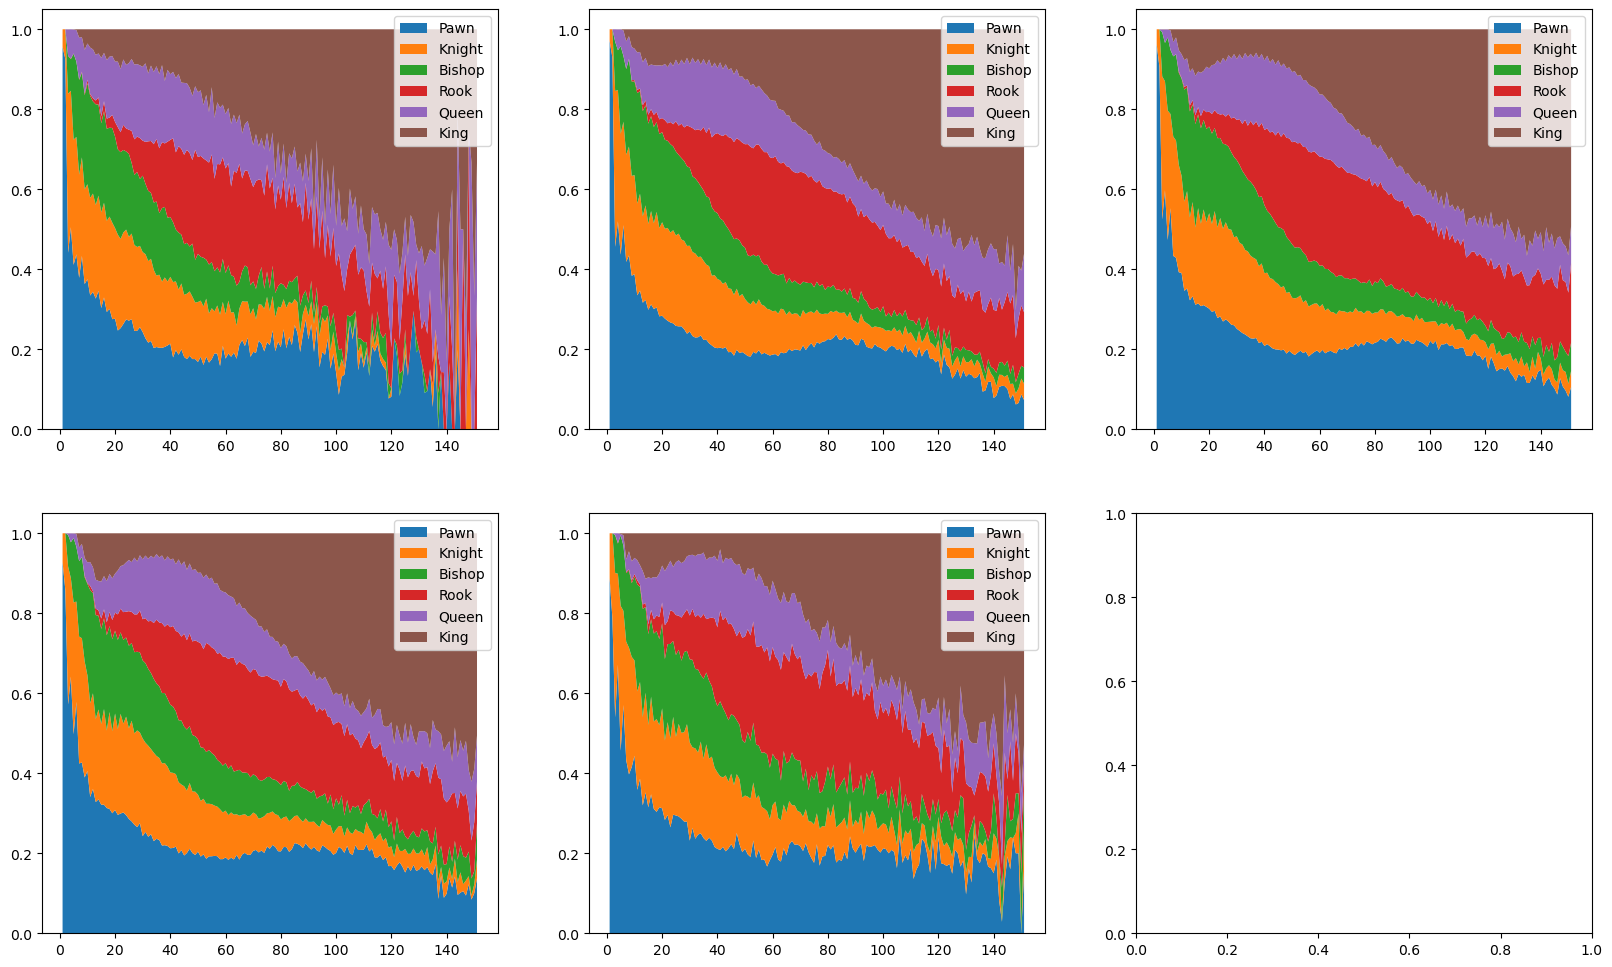

In [31]:
# REDUNDANT
# Iterate the elo-range split df
fig, ax = plt.subplots(2,3,figsize = (20,12))
ctr = 0
for i in range(0,2):
    for j in range(0,3):
        df = pc_all[ctr][:151]
        # df = df.divide(df.sum(axis=1), axis=0) #comment out if dont want normalized
        x = list(range(1, len(df)+1))
        ax[i][j].stackplot(x, df.transpose())
        ax[i][j].legend(list(df.columns))
        ctr+=1
        if(ctr>=5):break
plt.show()

In [80]:
# Animated stacked area chart for piece distribution
pc_all = pickle.load(open('./pc_all_list.pkl', 'rb'))

elo_bins = {
    0: "<1200", 
    1: "1200-1500", 
    2: "1500-1800", 
    3: "1800-2100", 
    4: ">2100"
}

for idx, df in enumerate(pc_all):
    df = pc_all[idx][:151]
    df = df.divide(df.sum(axis=1), axis=0) #comment out if dont want normalized
    df["Elo Range"] = elo_bins[idx]
    df["Ply"] = df.index+1
    cols = ["Ply", "Elo Range", "Pawn", "Knight", "Bishop", "Rook", "Queen", "King"]
    df = df[cols]
    pc_all[idx] = df
pc_all_concat = pd.concat(pc_all)

pc_all_melt = pd.melt(pc_all_concat, id_vars=["Ply", "Elo Range"], value_vars=["Pawn", "Knight", "Bishop", "Rook", "Queen", "King"])
pc_all_melt.columns = ["Ply", "Elo Range", "Piece", "Move Percentage"]

fig = px.area(pc_all_melt, x="Ply", y="Move Percentage", line_group="Piece", color="Piece",
  animation_frame="Elo Range", animation_group="Piece", range_y=[0,1])
fig.show()

In [ ]:
# Animate above but with box/violinplots/overlaid KDE showing distribution for individual pieces

In [ ]:
# Interesting to note that for low elo <1200, the spike from the king's castling move is not as apparent and
# thus development of the rooks is much later into the game, whereas the queen is much more active and contributes to
# games ending quicker due to opponents falling for traps, attacks, etc. at low levels

In [167]:
# Move 31 (half)
for i in range(0, len(piece_count)):
    if(piece_count.loc[i].sum() < len(gamelist)/2):
        print(i)
        break

62


100%|████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 390272.37it/s]


<Axes: ylabel='Count'>

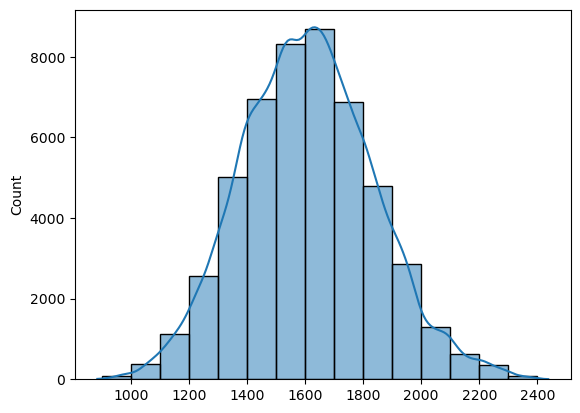

In [51]:
# Simple Elo distribution on lichess for basic visualization to introduce
avg_elo_list = []
for game in tqdm(gamelist):
    avg_elo = (int(game.headers["WhiteElo"]) + int(game.headers["BlackElo"]))/2
    avg_elo_list.append(avg_elo)
bin_edges = [900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400]
sns.histplot(avg_elo_list, bins=bin_edges, kde=False)

In [19]:
# Bivariate exploration: Move lengths across elo ranges (Multiple histograms or something)
elo_range_movecounts = {
    "<1200": [], 
    "1200-1500": [], 
    "1500-1800": [],
    "1800-2100": [],
    ">2100": []
}

for game in tqdm(gamelist):
    # Skip abandoned games
    if(game.headers["Termination"] == "Abandoned"):
        continue
    
    ply_ctr = 0
    avg_elo = (int(game.headers["WhiteElo"]) + int(game.headers["BlackElo"]))/2
    
    board = game.board()
    for move in game.mainline_moves():
        move_san = board.san(move)
        board.push(move)
        ply_ctr += 1
        
    # Prune extreme outliers
    if ply_ctr >250: continue   # Comment out if want full graph
    
    if(avg_elo < 1200):
        elo_range_movecounts["<1200"].append(ply_ctr)
    elif(avg_elo in np.arange(1200, 1500, 0.5)):
        elo_range_movecounts["1200-1500"].append(ply_ctr)
    elif(avg_elo in np.arange(1500, 1800, 0.5)):
        elo_range_movecounts["1500-1800"].append(ply_ctr)
    elif(avg_elo in np.arange(1800, 2100, 0.5)):
        elo_range_movecounts["1800-2100"].append(ply_ctr)
    elif(avg_elo >= 2100):
        elo_range_movecounts[">2100"].append(ply_ctr)
        


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:36<00:00, 148.80it/s]


<Axes: >

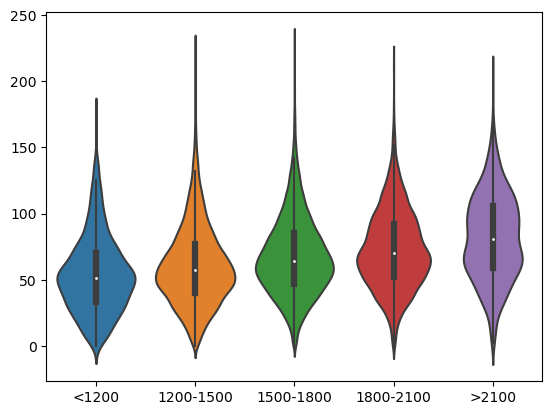

In [182]:
# Boxplot to show change in movecount distributions as elo increases
# Change axes and stuff respectively
max_length = max(len(v) for v in elo_range_movecounts.values())
for key in elo_range_movecounts:
    elo_range_movecounts[key] = elo_range_movecounts[key] + [float('nan')] * (max_length - len(elo_range_movecounts[key]))

movecounts_elo = pd.DataFrame.from_dict(elo_range_movecounts)
sns.violinplot(movecounts_elo)

# Can be used to explain endgame mastery, average game length

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:13<00:00, 679.32it/s]


{'Time forfeit': 17372, 'Abandoned': 568, 'Draw': 1346, 'Resignation': 18567, 'Checkmate': 12145, 'Rules infraction': 2}


<Axes: xlabel='File'>

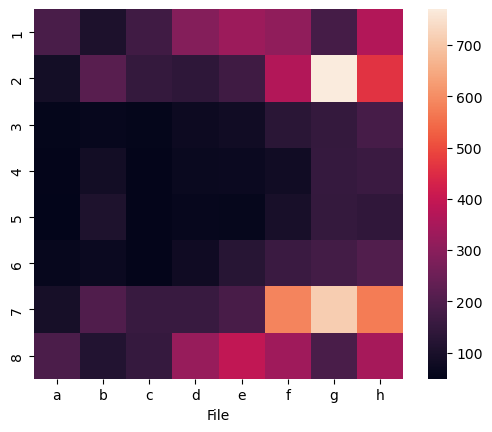

In [168]:
# Game end piechart
# Extend to Extracting checkmating squares and pieces
checkmate_heatmap = pd.read_csv("sfc_template.csv", header=0, index_col="File")
checkmate_piece_count = {"King": 0, "Queen":0,"Rook":0,"Bishop":0,"Knight":0,"Pawn":0}
game_end = {"Time forfeit": 0, "Abandoned": 0, "Draw":0, "Resignation": 0, "Checkmate": 0, "Rules infraction": 0}

for game in tqdm(gamelist):
    termination = game.headers["Termination"]
    board = game.board()
    
    if(termination != "Normal"):
        game_end[termination]+=1
    else:
        # Iterate until last move
        move_last = ""
        for move in game.mainline_moves():
            move_san = board.san(move)
            move_last = move_san
            board.push(move)
            
        # Increment category and log square
        move_last_list = list(move_last)
        if(len(move_last_list) == 0): game_end["Resignation"]+=1
            
        elif(move_last_list[-1] == '#'): # Checkmate
            game_end["Checkmate"] += 1
            sq = []
            if(move_last_list[-2] not in piece_list ): # Not promotion checkmate
                sq = move_last_list[-3:-1]
                # Get piece
                piece = move_last_list[0]
                if(piece.isupper()): # Not pawn checkmate
                    checkmate_piece_count[piecedict[piece]] += 1
                else: # Pawn checkmate
                    checkmate_piece_count["Pawn"] += 1
            else:
                sq = move_last_list[-5:-3]
                # Get promoted piece
                piece = move_last_list[-2]
                checkmate_piece_count[piecedict[piece]] += 1 # Can't be a pawn checkmate
                
                
            checkmate_heatmap.loc[sq[0]][sq[1]] += 1
        else: 
            if(game.headers["Result"] == '1/2-1/2'): game_end["Draw"] += 1
            else: game_end["Resignation"] += 1

sns.heatmap(checkmate_heatmap.transpose(), square=True)

In [179]:
# Checkmate exceptions
# Discovered check https://lichess.org/evxNRVSn#47